In [1]:
from typing import SupportsFloat, Sequence, Tuple, Any
import collections

In [2]:
from rlplg import envplay
from rlplg.learning.tabular import policies

In [3]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import wrappers as gym_wrappers
from gymnasium.core import ObsType, ActType

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

## Utils

In [5]:
def collect_stats(env, total_episodes: int = 2000):
    policy = policies.PyRandomPolicy(num_actions=env.action_space.n)
    # collect data
    idx = 1
    end_game = []
    rewards = set()
    while True:
        traj = tuple(envplay.generate_episodes(env, policy=policy, num_episodes=1))
        for step, traj_step in enumerate(traj):
            rewards.add(traj_step.reward)
            pass
        end_game.append(step + 1)
        if idx % 500 == 0:
            print(f"Iteration {idx}")
        if idx > total_episodes:
            break
        idx += 1
    return sorted(collections.Counter(end_game).items()), sorted(rewards)

In [6]:
class ShiftReward(gym.RewardWrapper):
    def __init__(self, env: gym.Env[ObsType, ActType], delta: float):
        """Constructor for the Reward wrapper."""
        super().__init__(env)
        self.delta = delta
        self.reward_range = (env.reward_range[0] + delta, env.reward_range[1] + delta)
    
    def reward(self, reward: SupportsFloat) -> SupportsFloat:
        return reward + self.delta

In [7]:
def plot(xs: Sequence[Tuple[Any, int]], xlabel: str):
    values, weights = zip(*xs)
    _, ax = plt.subplots()
    df = pd.DataFrame({"values": values, "weights": weights})
    sns.ecdfplot(df, x="values", weights="weights", ax=ax)
    ax.set_xlabel(xlabel)

In [8]:
def run_env(env, total_episodes: int = 2500):
    print(env)
    print(vars(env))
    egs, rs = collect_stats(env, total_episodes=total_episodes)
    print("End game", egs)
    print("Rewards", rs)
    plot(egs, xlabel="Episode ending step")

## FrozenLake

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
{'_saved_kwargs': {'max_episode_steps': 100}, 'env': <OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 100, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(3, 300), (4, 265), (5, 277), (6, 247), (7, 248), (8, 191), (9, 155), (10, 160), (11, 117), (12, 104), (13, 78), (14, 62), (15, 40), (16, 43), (17, 47), (18, 28), (19, 19), (20, 22), (21, 21), (22, 11), (23, 11), (24, 10), (25, 4), (26, 7), (27, 8), (28, 2), (29, 4), (30, 5), (31, 4), (32, 2), (33, 1), (35, 2), (36, 1), (40, 1), (42, 1), (44, 1), (47, 1), (58, 1)]
Rewards [0.0, 1.0]


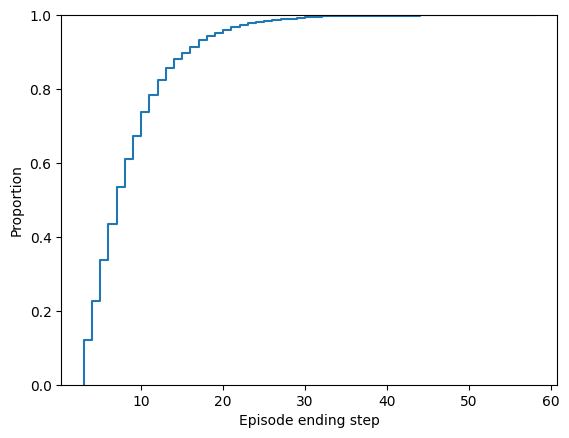

In [9]:
run_env(gym.make("FrozenLake-v1", is_slippery=False))

<ShiftReward<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>>
{'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>, '_action_space': None, '_observation_space': None, '_reward_range': (-1.0, 0.0), '_metadata': None, '_cached_spec': None, 'delta': -1.0}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(3, 299), (4, 287), (5, 276), (6, 257), (7, 213), (8, 156), (9, 169), (10, 144), (11, 127), (12, 103), (13, 59), (14, 67), (15, 47), (16, 47), (17, 37), (18, 40), (19, 29), (20, 22), (21, 19), (22, 13), (23, 17), (24, 8), (25, 8), (26, 13), (27, 3), (28, 5), (29, 8), (30, 3), (31, 4), (32, 4), (33, 4), (34, 4), (36, 2), (37, 1), (38, 2), (41, 1), (48, 1), (54, 1), (61, 1)]
Rewards [-1.0, 0.0]


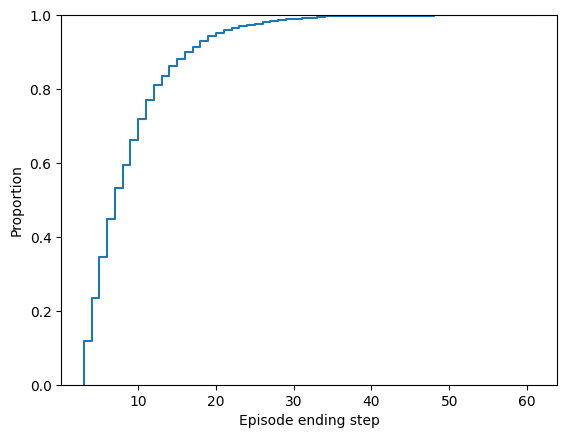

In [10]:
run_env(ShiftReward(gym.make("FrozenLake-v1", is_slippery=False), delta=-1.0))

## CliffWalking

<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>
{'_saved_kwargs': {'disable_render_order_enforcing': False}, 'env': <PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_has_reset': False, '_disable_render_order_enforcing': False}
End game [(112, 1), (183, 1), (230, 1), (356, 1), (358, 1), (419, 1), (461, 1), (688, 1), (757, 1), (833, 1), (892, 1), (911, 1), (922, 1), (929, 1), (1077, 1), (1085, 1), (1150, 1), (1241, 1), (1285, 1), (1405, 1), (1412, 1), (1433, 1), (1435, 1), (1466, 1), (1663, 1), (1691, 1), (1747, 1), (1782, 1), (1795, 1), (1844, 1), (1848, 1), (2001, 1), (2075, 1), (2398, 1), (2445, 1), (2574, 1), (2644, 1), (2754, 1), (2778, 1), (2810, 1), (2816, 1), (2869, 1), (3240, 1), (3387, 1), (3481, 1), (3534, 1), (3535, 1), (3810, 1), (3832, 1), (3899, 1), (3925, 1), (4042, 1), (4193, 1), (4608, 1), (4697, 1), (4806, 1), (5035, 1), (5533,

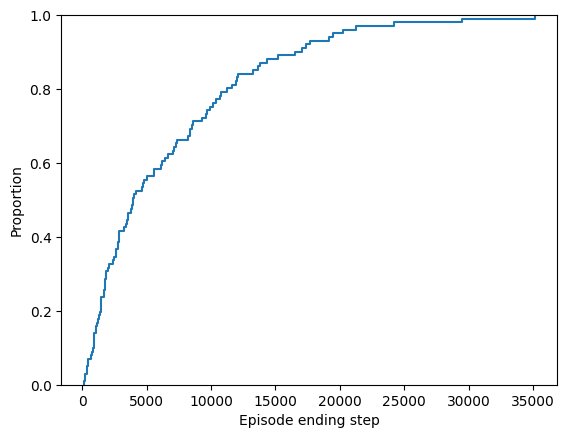

In [11]:
run_env(gym.make("CliffWalking-v0"), total_episodes=100)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>>
{'_saved_kwargs': {'max_episode_steps': 2500}, 'env': <OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 2500, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(43, 1), (54, 1), (57, 1), (59, 1), (61, 1), (62, 2), (65, 1), (74, 1), (77, 1), (78, 1), (81, 1), (83, 2), (84, 1), (86, 1), (87, 1), (96, 1), (98, 1), (102, 1), (106, 1), (107, 1), (110, 1), (112, 1), (114, 1), (121, 1), (123, 1), (124, 1), (126, 1), (130, 1), (134, 2), (136, 1), (139, 2), (141, 1), (143, 1), (150, 1), (152, 1), (156, 1), (157, 1), (159, 1), (160, 1), (161, 1), (164, 1), (165, 2), (167, 1), (170, 1), (171, 1), (172, 1), (173, 1), (189, 1), (190, 1), (191, 1), (193, 1), (195, 2), (198, 1), (202, 1), (210, 1), (212, 1), 

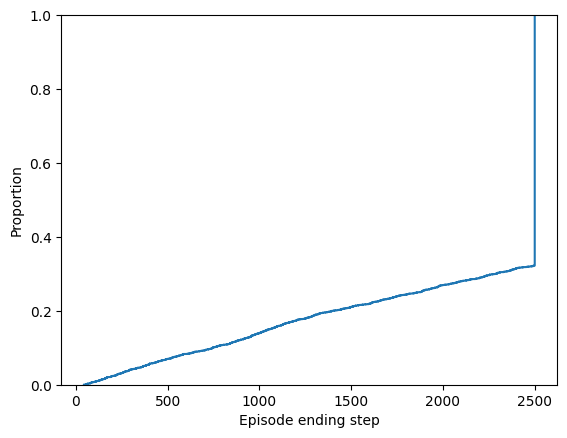

In [12]:
run_env(gym.make("CliffWalking-v0", max_episode_steps=2500))

Between [20-35%) of episodes would end before 2500 steps.

## Taxi-v3

We override the default limit of 200 steps, since it creates a scarcity of observations of the final state.

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>
{'_saved_kwargs': {'max_episode_steps': inf}, 'env': <OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': inf, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(14, 1), (17, 1), (33, 2), (49, 2), (54, 1), (55, 1), (56, 2), (59, 1), (64, 2), (67, 1), (69, 1), (71, 2), (76, 2), (78, 1), (80, 1), (81, 2), (82, 1), (83, 2), (85, 2), (88, 1), (91, 1), (92, 1), (93, 1), (95, 1), (97, 2), (98, 2), (100, 2), (102, 1), (103, 1), (104, 1), (107, 2), (109, 2), (110, 1), (111, 1), (115, 2), (116, 3), (118, 1), (119, 1), (120, 1), (122, 1), (124, 3), (125, 1), (127, 1), (129, 1), (130, 1), (131, 1), (134, 1), (138, 2), (140, 1), (141, 2), (146, 1), (147, 4), (148, 1), (150, 1), (151, 2), (152, 1), (153, 2), (156, 2), (158, 2), (159, 1), (16

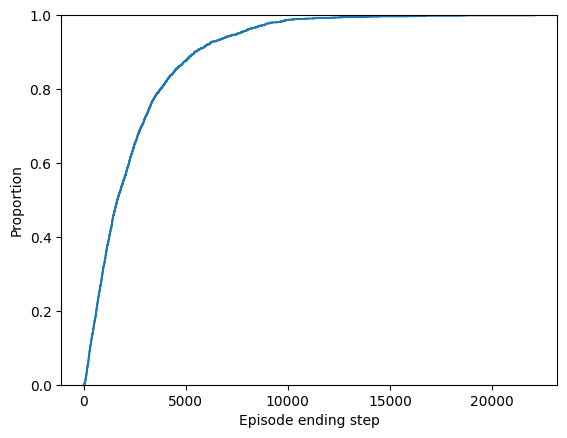

In [13]:
run_env(gym.make("Taxi-v3", max_episode_steps=np.inf))

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>
{'_saved_kwargs': {'max_episode_steps': 2500}, 'env': <OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 2500, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(25, 1), (30, 1), (34, 1), (37, 1), (42, 1), (43, 2), (44, 1), (45, 1), (48, 2), (52, 1), (55, 1), (57, 1), (62, 1), (65, 1), (66, 1), (72, 2), (74, 1), (78, 1), (79, 3), (80, 1), (81, 1), (86, 1), (88, 2), (89, 2), (91, 1), (93, 1), (94, 2), (95, 2), (96, 1), (97, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (108, 1), (110, 1), (113, 2), (114, 1), (116, 2), (117, 1), (119, 3), (122, 1), (123, 2), (127, 2), (129, 1), (130, 3), (131, 1), (133, 2), (134, 1), (135, 1), (137, 1), (140, 1), (141, 2), (142, 1), (143, 1), (144, 1), (145, 1), (147, 3), (150, 1), (151,

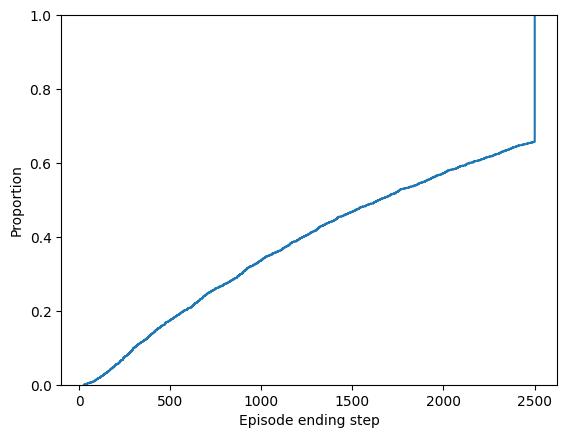

In [14]:
run_env(gym.make("Taxi-v3", max_episode_steps=2500))

About ~60% of episodes end before step 2500. We also observe the reward for successful outcomes, so the terminal states should be present in the data buffer.

## Blackjack

Blackjack is already a discrete state problem. We need only convert its 3-tuple state into a single `int` value.
Though the environment is unsuitable for DAAF, since it's a sparse reward problem - with rewards given only at the end.

<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>
{'_saved_kwargs': {'disable_render_order_enforcing': False}, 'env': <PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_has_reset': False, '_disable_render_order_enforcing': False}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(2, 1741), (3, 623), (4, 118), (5, 18), (6, 1)]
Rewards [-1.0, 0.0, 1.0]


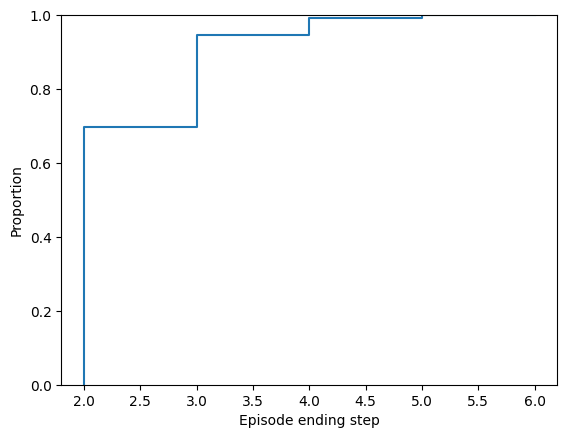

In [15]:
run_env(gym.make("Blackjack-v1"))

In [16]:
env = gym_wrappers.FlattenObservation(gym.make("Blackjack-v1"))
print(env.observation_space)
print(env.reset())

Box(0, 1, (45,), int64)
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0]), {})


`FlattenObservation` generates OHE arrays instead of integers for states.
Will need a custom process to discretize blackjack.

In [17]:
env = gym.make("Blackjack-v1")
dims = [space.n for space in env.observation_space]
print(dims)
current_sum, dealer_hand, has_ace = dims
size = np.product(dims)
pos_hist = {}
idx = 0
for csum in range(current_sum):
    for hand in range(dealer_hand):
        for ace in range(has_ace):
            pos_hist[(csum, hand, ace)] = idx
            idx += 1

assert size == len(pos_hist), f"{size} != {len(pos_hist)}"

[32, 11, 2]


## Mountain Car

In [18]:
# https://gymnasium.farama.org/environments/classic_control/mountain_car/
# speed and velocity changes
# velocityt+1 = velocityt + (action - 1) * force - cos(3 * positiont) * gravity
# positiont+1 = positiont + velocityt+1
# velocity delta
force = 0.001
gravity = 0.0025
positions = []
speeds = []
deltas = []
for positiont in np.arange(-1.2, 0.6, 0.1):
    for velocity in np.arange(-0.7, 0.7, 0.1):
        for action in range(3):
            delta = (action - 1) * force - np.cos(3 * positiont) * gravity
            v_ = velocity + delta
            deltas.append(delta)
            speeds.append(v_)
            positions.append(positiont + v_)

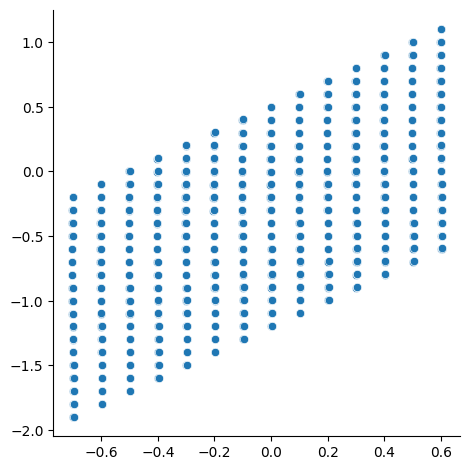

In [19]:
sns.relplot(x=speeds, y=positions)

<Axes: ylabel='Count'>

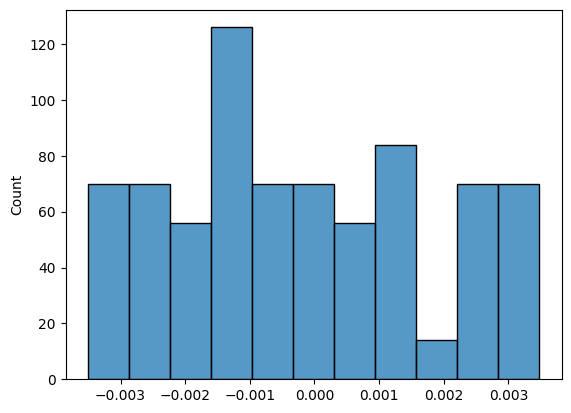

In [20]:
sns.histplot(deltas)

Differences are very minute. Discretization would lead to very large state spaces

In [21]:
# state space after discretization
len(np.arange(-1.2, 0.6, 0.001)) * len(np.arange(-0.7, 0.7, 0.001))

2520000